## Importing some packages

In [68]:
import os.path
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from statsmodels.stats.contingency_tables import mcnemar

from config import *

## Loading the data

In [69]:
results_general = pd.read_csv(os.path.join(work_dir, 'results_general.csv'))
results_spherical = pd.read_csv(os.path.join(work_dir, 'results_spherical.csv'))

## Setting some global parameters

In [70]:
figsize= (7.5, 3.3)

## General distortions

### Plotting the figure of matching exact and simulated figures and AUC scores

relative variation for noisy window b
2                 5.6e-06
5                 9.3e-05
sturges-formula   4.0e-05
rice-rule         2.0e-05
square-root       1.5e-05
dtype: float64
relative variation for distorted template (general distortion) b
2                 1.7e-03
5                 4.0e-03
sturges-formula   3.3e-03
rice-rule         3.7e-03
square-root       3.3e-03
dtype: float64


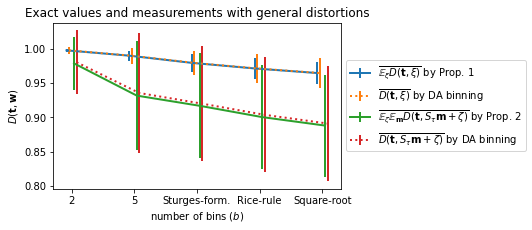

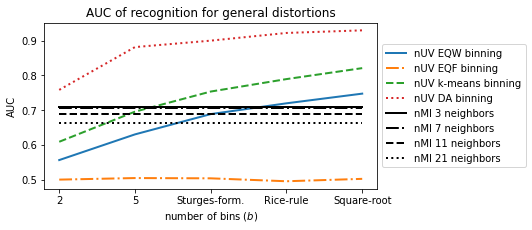

In [71]:
grouped= results_general.groupby(['b']).agg(['mean', 'std'])

grouped= grouped.loc[['2', '5', 'sturges-formula', 'rice-rule', 'square-root']]

print('relative variation for noisy window', abs(grouped[('exact_noise', 'mean')] - grouped[('distortion_aligned_noise', 'mean')])/grouped[('exact_noise', 'mean')])
print('relative variation for distorted template (general distortion)', abs(grouped[('exact_distortion', 'mean')] - grouped[('distortion_aligned_distorted', 'mean')])/grouped[('distortion_aligned_distorted', 'mean')])

fig, ax= plt.subplots(figsize=figsize)
trans0= Affine2D().translate(-0.08, 0.0) + ax.transData
trans1= Affine2D().translate(-0.04, 0.0) + ax.transData
trans2= Affine2D().translate(-0.0, 0.0) + ax.transData
trans3= Affine2D().translate(0.04, 0.0) + ax.transData
trans4= Affine2D().translate(0.08, 0.0) + ax.transData

ax.errorbar(np.arange(len(grouped)), grouped[('exact_noise', 'mean')], grouped[('exact_noise', 'std')], label='$\\overline{\\mathbb{E}_\\xi D(\\mathbf{t},\\xi)}$ by Prop. 1', linestyle='-', linewidth=2.0, transform=trans0)
ax.errorbar(np.arange(len(grouped)), grouped[('distortion_aligned_noise', 'mean')], grouped[('distortion_aligned_noise', 'std')], label='$\\overline{D(\\mathbf{t}, \\xi)}$ by DA binning', linewidth=2.0, linestyle=':', transform=trans1)
ax.errorbar(np.arange(len(grouped)), grouped[('exact_distortion', 'mean')], grouped[('exact_distortion', 'std')], label='$\\overline{\\mathbb{E}_\\zeta\\mathbb{E}_\\mathbf{m} D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by Prop. 2', linestyle='solid', linewidth=2.0, transform=trans3)
ax.errorbar(np.arange(len(grouped)), grouped[('distortion_aligned_distorted', 'mean')], grouped[('distortion_aligned_distorted', 'std')], label='$\\overline{D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by DA binning', linewidth=2.0, linestyle=':', transform=trans4)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('number of bins ($b$)')
ax.set_ylabel('$D(\mathbf{t},\mathbf{w})$')
ax.set_title('Exact values and measurements with general distortions')
ax.set_xticks(np.arange(len(grouped)))
ax.set_xticklabels(['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('fit_general.pdf')

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped)), grouped[('eqw_hits', 'mean')], label='nUV EQW binning', linestyle='-', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='nUV EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped)), grouped[('kmeans_hits', 'mean')], label='nUV k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('distortion_aligned_hits', 'mean')], label='nUV DA binning', linewidth=2.0, linestyle=':')
for i, n in enumerate(mi_n_neighbors_simulation_general):
    plt.plot(np.arange(len(grouped)), grouped[('mi_' + str(n) + '_hits', 'mean')], label='nMI ' + str(n) + ' neighbors', linewidth=2.0, linestyle=['-', '-.', '--', ':', (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][i], c='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('number of bins ($b$)')
plt.ylabel('AUC')
plt.title('AUC of recognition for general distortions')
plt.xticks(np.arange(len(grouped)), ['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('auc_general.pdf')

### Executing the statistical tests

In [72]:
results_general.columns

Index(['d', 'b', 'b_mods', 'sigma', 'sigma_m', 'exact_noise',
       'exact_distortion', 'exact_kmeans', 'steps', 'd_tau', 'id', 'eqw_noise',
       'eqw_distorted', 'eqw_hits', 'eqw_runtime', 'eqf_noise',
       'eqf_distorted', 'eqf_hits', 'eqf_runtime', 'kmeans_noise',
       'kmeans_distorted', 'kmeans_hits', 'kmeans_runtime',
       'distortion_aligned_noise', 'distortion_aligned_distorted',
       'distortion_aligned_hits', 'distortion_aligned_runtime', 'mi_3_hits',
       'mi_3_runtime', 'mi_7_hits', 'mi_7_runtime', 'mi_11_hits',
       'mi_11_runtime', 'mi_21_hits', 'mi_21_runtime'],
      dtype='object')

In [73]:
results_square_root= results_general[results_general['b'] == 'square-root']

means= np.array([np.mean(results_general['eqw_hits']), 
                 np.mean(results_general['eqf_hits']), 
                 np.mean(results_general['kmeans_hits']), 
                 np.mean(results_general['distortion_aligned_hits']),
                 np.mean(results_general['mi_3_hits']),
                 np.mean(results_general['mi_7_hits']),
                 np.mean(results_general['mi_11_hits']),
                 np.mean(results_general['mi_21_hits'])])

binning_methods_mi= binning_methods + ['mi_' + str(i) for i in mi_n_neighbors_simulation_general]

p_matrix_general= np.zeros(shape=(len(binning_methods_mi), len(binning_methods_mi)))

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        p_matrix_general[i][j]= ttest_rel(results_square_root[b0 + '_hits'], results_square_root[b1 + '_hits'])[1]

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_general, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for general distortions with paired t-test")
print(p.to_latex())

p_matrix_general= np.zeros(shape=(len(binning_methods_mi), len(binning_methods_mi)))

table= np.zeros(shape=(2,2))

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        a= results_square_root[b0 + '_hits'].values
        b= results_square_root[b1 + '_hits'].values

        for k in [0, 1]:
            for l in [0, 1]:
                table[k,l]= np.sum(np.logical_and(a == k, b == l))

        p_matrix_general[i][j]= mcnemar(table).pvalue

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_general, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for general distortions with mcnemar test")
print(p.to_latex())


the matrix of p-values and mean AUCs for general distortions with paired t-test
\begin{tabular}{lrrrrrrrr}
\toprule
{} &      eqw &      eqf &   kmeans &  distortion\_aligned &     mi\_3 &     mi\_7 &    mi\_11 &    mi\_21 \\
\midrule
eqw                &  1.0e+00 & 1.6e-281 &  3.7e-59 &             0.0e+00 &  2.0e-10 &  2.1e-13 &  5.5e-24 &  3.6e-46 \\
eqf                & 1.6e-281 &  1.0e+00 &  0.0e+00 &             0.0e+00 & 1.3e-194 & 8.3e-187 & 1.1e-158 & 1.2e-115 \\
kmeans             &  3.7e-59 &  0.0e+00 &  1.0e+00 &            2.7e-164 &  4.2e-91 & 9.2e-101 & 2.8e-126 & 4.3e-171 \\
distortion\_aligned &  0.0e+00 &  0.0e+00 & 2.7e-164 &             1.0e+00 &  0.0e+00 &  0.0e+00 &  0.0e+00 &  0.0e+00 \\
mi\_3               &  2.0e-10 & 1.3e-194 &  4.2e-91 &             0.0e+00 &  1.0e+00 &  2.6e-01 &  1.8e-05 &  1.7e-17 \\
mi\_7               &  2.1e-13 & 8.3e-187 & 9.2e-101 &             0.0e+00 &  2.6e-01 &  1.0e+00 &  2.3e-05 &  6.8e-16 \\
mi\_11              &  5.5e-24 & 1.1

In [74]:
tmp=results_general[['b'] + [c for c in results_general.columns if c.endswith('hits')]].groupby(['b']).mean().T
tmp

b,2,5,rice-rule,square-root,sturges-formula
eqw_hits,5.6e-01,6.3e-01,7.2e-01,7.5e-01,6.9e-01
eqf_hits,5.0e-01,5.1e-01,5.0e-01,5.0e-01,5.0e-01
kmeans_hits,6.1e-01,7.0e-01,7.9e-01,8.2e-01,7.5e-01
distortion_aligned_hits,7.6e-01,8.8e-01,9.2e-01,9.3e-01,9.0e-01
mi_3_hits,7.1e-01,7.1e-01,7.1e-01,7.1e-01,7.1e-01
mi_7_hits,7.1e-01,7.1e-01,7.1e-01,7.1e-01,7.1e-01
mi_11_hits,6.9e-01,6.9e-01,6.9e-01,6.9e-01,6.9e-01
mi_21_hits,6.6e-01,6.6e-01,6.6e-01,6.6e-01,6.6e-01


## Spherical distortions

### Plotting the figure of matching exact and simulated figures and AUC scores

relative variation for noisy window b
2                 7.4e-05
5                 4.3e-05
sturges-formula   6.4e-05
rice-rule         6.2e-05
square-root       1.5e-04
dtype: float64
relative variation for distorted template (spherical distortion) b
2                 5.3e-03
5                 1.1e-04
sturges-formula   8.9e-05
rice-rule         1.3e-05
square-root       1.1e-04
dtype: float64


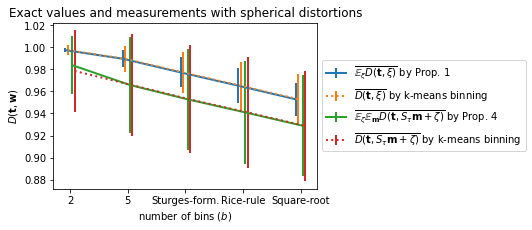

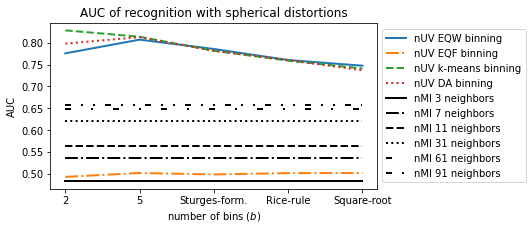

In [75]:
grouped= results_spherical.groupby(['b']).agg(['mean', 'std'])

grouped= grouped.loc[['2', '5', 'sturges-formula', 'rice-rule', 'square-root']]

print('relative variation for noisy window', abs(grouped[('exact_noise', 'mean')] - grouped[('kmeans_noise', 'mean')])/grouped[('exact_noise', 'mean')])
print('relative variation for distorted template (spherical distortion)', abs(grouped[('exact_kmeans', 'mean')] - grouped[('kmeans_distorted', 'mean')])/grouped[('exact_kmeans', 'mean')])

fig, ax= plt.subplots(figsize=figsize)
trans0= Affine2D().translate(-0.08, 0.0) + ax.transData
trans1= Affine2D().translate(-0.04, 0.0) + ax.transData
trans2= Affine2D().translate(-0.0, 0.0) + ax.transData
trans3= Affine2D().translate(0.04, 0.0) + ax.transData
trans4= Affine2D().translate(0.08, 0.0) + ax.transData
trans5= Affine2D().translate(0.12, 0.0) + ax.transData

ax.errorbar(np.arange(len(grouped)), grouped[('exact_noise', 'mean')], grouped[('exact_noise', 'std')], label='$\\overline{\\mathbb{E}_\\xi D(\\mathbf{t},\\xi)}$ by Prop. 1', linestyle='-', linewidth=2.0, transform=trans0)
ax.errorbar(np.arange(len(grouped)), grouped[('kmeans_noise', 'mean')], grouped[('kmeans_noise', 'std')], label='$\\overline{D(\\mathbf{t}, \\xi)}$ by k-means binning', linewidth=2.0, linestyle=':', transform=trans1)
ax.errorbar(np.arange(len(grouped)), grouped[('exact_kmeans', 'mean')], grouped[('exact_kmeans', 'std')], label='$\\overline{\\mathbb{E}_\\zeta\\mathbb{E}_\\mathbf{m} D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by Prop. 4', linestyle='solid', linewidth=2.0, transform=trans3)
ax.errorbar(np.arange(len(grouped)), grouped[('kmeans_distorted', 'mean')], grouped[('kmeans_distorted', 'std')], label='$\\overline{D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by k-means binning', linewidth=2.0, linestyle=':', transform=trans4)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('number of bins ($b$)')
ax.set_ylabel('$D(\mathbf{t},\mathbf{w})$')
ax.set_title('Exact values and measurements with spherical distortions')
ax.set_xticks(np.arange(len(grouped)))
ax.set_xticklabels(['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('fit_spherical.pdf')

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped)), grouped[('eqw_hits', 'mean')], label='nUV EQW binning', linestyle='-', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='nUV EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped)), grouped[('kmeans_hits', 'mean')], label='nUV k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('distortion_aligned_hits', 'mean')], label='nUV DA binning', linewidth=2.0, linestyle=':')
for i, n in enumerate(mi_n_neighbors_simulation_spherical):
    plt.plot(np.arange(len(grouped)), grouped[('mi_' + str(n) + '_hits', 'mean')], label='nMI ' + str(n) + ' neighbors', linewidth=2.0, linestyle=['-', '-.', '--', ':', (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))][i], c='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('number of bins ($b$)')
plt.ylabel('AUC')
plt.title('AUC of recognition with spherical distortions')
plt.xticks(np.arange(len(grouped)), ['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('auc_spherical.pdf')


### Executing the statistical tests

In [76]:
means= np.array([np.mean(results_spherical['eqw_hits']), 
                 np.mean(results_spherical['eqf_hits']), 
                 np.mean(results_spherical['kmeans_hits']), 
                 np.mean(results_spherical['distortion_aligned_hits']),
                 np.mean(results_spherical['mi_3_hits']),
                 np.mean(results_spherical['mi_7_hits']),
                 np.mean(results_spherical['mi_11_hits']),
                 np.mean(results_spherical['mi_31_hits']),
                 np.mean(results_spherical['mi_61_hits']),
                 np.mean(results_spherical['mi_91_hits'])])

results_spherical_2= results_spherical[results_spherical['b'] == '2']

binning_methods_mi= binning_methods + ['mi_' + str(i) for i in mi_n_neighbors_simulation_spherical]

p_matrix_spherical= np.zeros(shape=(len(binning_methods_mi), len(binning_methods_mi)))

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        p_matrix_spherical[i][j]= ttest_rel(results_spherical_2[b0 + '_hits'], results_spherical_2[b1 + '_hits'])[1]

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_spherical, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for spherical distortions")
print(p.to_latex())

for i, b0 in enumerate(binning_methods_mi):
    for j, b1 in enumerate(binning_methods_mi):
        a= results_spherical_2[b0 + '_hits'].values
        b= results_spherical_2[b1 + '_hits'].values

        for k in [0, 1]:
            for l in [0, 1]:
                table[k,l]= np.sum(np.logical_and(a == k, b == l))

        p_matrix_spherical[i][j]= mcnemar(table).pvalue

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_spherical, means]), 
                columns= binning_methods_mi, 
                index=binning_methods_mi + ['AUC']).fillna(1)

print("the matrix of p-values and mean AUCs for spherical distortions with mcnemar test")
print(p.to_latex())

the matrix of p-values and mean AUCs for spherical distortions
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &      eqw &      eqf &   kmeans &  distortion\_aligned &     mi\_3 &    mi\_7 &    mi\_11 &    mi\_31 &    mi\_61 &    mi\_91 \\
\midrule
eqw                &  1.0e+00 &  0.0e+00 &  8.3e-29 &             5.9e-06 &  0.0e+00 & 0.0e+00 & 8.6e-265 & 5.6e-156 & 2.0e-115 &  2.1e-99 \\
eqf                &  0.0e+00 &  1.0e+00 &  0.0e+00 &             0.0e+00 &  1.6e-01 & 7.0e-10 &  2.2e-23 &  1.2e-74 & 7.8e-108 & 3.3e-121 \\
kmeans             &  8.3e-29 &  0.0e+00 &  1.0e+00 &             1.2e-21 &  0.0e+00 & 0.0e+00 &  0.0e+00 & 1.7e-307 & 4.9e-249 & 4.4e-227 \\
distortion\_aligned &  5.9e-06 &  0.0e+00 &  1.2e-21 &             1.0e+00 &  0.0e+00 & 0.0e+00 &  0.0e+00 & 2.7e-212 & 3.9e-159 & 1.5e-142 \\
mi\_3               &  0.0e+00 &  1.6e-01 &  0.0e+00 &             0.0e+00 &  1.0e+00 & 5.7e-23 &  3.9e-42 & 2.9e-105 & 2.0e-143 & 4.1e-155 \\
mi\_7               &  0.0e+00 &  7.0e-10 &  

In [77]:
tmp=results_spherical_2[['b'] + [c for c in results_spherical.columns if c.endswith('hits')]].groupby(['b']).mean().T
tmp

b,2
eqw_hits,7.8e-01
eqf_hits,4.9e-01
kmeans_hits,8.3e-01
distortion_aligned_hits,8.0e-01
mi_3_hits,4.8e-01
mi_7_hits,5.4e-01
mi_11_hits,5.6e-01
mi_31_hits,6.2e-01
mi_61_hits,6.5e-01
mi_91_hits,6.6e-01


## Runtimes

In [78]:
np.mean(results_square_root[[c for c in results_square_root.columns if c.endswith('runtime')]])

eqw_runtime                  2.2e-03
eqf_runtime                  8.8e-04
kmeans_runtime               3.3e-03
distortion_aligned_runtime   5.3e-02
mi_3_runtime                 8.4e-03
mi_7_runtime                 8.8e-03
mi_11_runtime                9.3e-03
mi_21_runtime                1.1e-02
dtype: float64

In [79]:
np.mean(results_spherical[[c for c in results_spherical.columns if c.endswith('runtime')]])

eqw_runtime                  1.4e-03
eqf_runtime                  8.0e-04
kmeans_runtime               2.4e-03
distortion_aligned_runtime   1.2e-01
mi_3_runtime                 8.3e-03
mi_7_runtime                 8.8e-03
mi_11_runtime                9.3e-03
mi_31_runtime                1.2e-02
mi_61_runtime                1.6e-02
mi_91_runtime                2.0e-02
dtype: float64